In [5]:
import torch
import torchvision
import os
import numpy as np

In [6]:
# 基于VOC数据集的预训练fcn语义分割模型 https://pytorch.org/vision/stable/models.html#table-of-all-available-semantic-segmentation-weights
from torchvision.models.segmentation import FCN_ResNet50_Weights
weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = torch.hub.load("pytorch/vision", "fcn_resnet50", weights=weights)

'''
# 用pytorch来下载VOC数据集到本地,但是不使用它的dataset,我们自己定义一个预处理简单点的dataset
dataset=torchvision.datasets.VOCSegmentation('vocdataset',image_set='train',download=True)
'''

Using cache found in C:\Users\liangdong/.cache\torch\hub\pytorch_vision_main


"\n# 用pytorch来下载VOC数据集到本地,但是不使用它的dataset,我们自己定义一个预处理简单点的dataset\ndataset=torchvision.datasets.VOCSegmentation('vocdataset',image_set='train',download=True)\n"

In [7]:
# target每种分类对应的颜色，一共21种分类，对应21种颜色
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    #print(idx.shape)
    #print(colormap2label[idx].shape)
    return colormap2label[idx]

def voc_label2colormap(labelmap):
    '''将像素分类映射回RGB值'''
    flat_labels=torch.reshape(labelmap,(-1,))
    colormap=[]
    for i,label in enumerate(flat_labels):
        colormap.append(VOC_COLORMAP[label])
    return torch.tensor(colormap).reshape(labelmap.shape[0],labelmap.shape[1],3)

def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

# 读取原始图片和标注图片
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        # VOC数据集的3通道各自的均值和误差
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)] # 扔掉尺寸不够裁剪的图片
        self.labels = self.filter(labels) # 对应的标注图片也扔掉
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255) # 像素先转0~1，再标准化

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        # 随机裁剪
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        # 标注图片的像素转分类
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [8]:
dataset=VOCSegDataset(True,crop_size=(320, 480),voc_dir='./vocdataset/VOCdevkit/VOC2012/')

read 1114 examples


torch.Size([10, 3, 320, 480]) torch.Size([10, 320, 480])
torch.Size([10, 21, 320, 480])
torch.Size([10, 320, 480])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

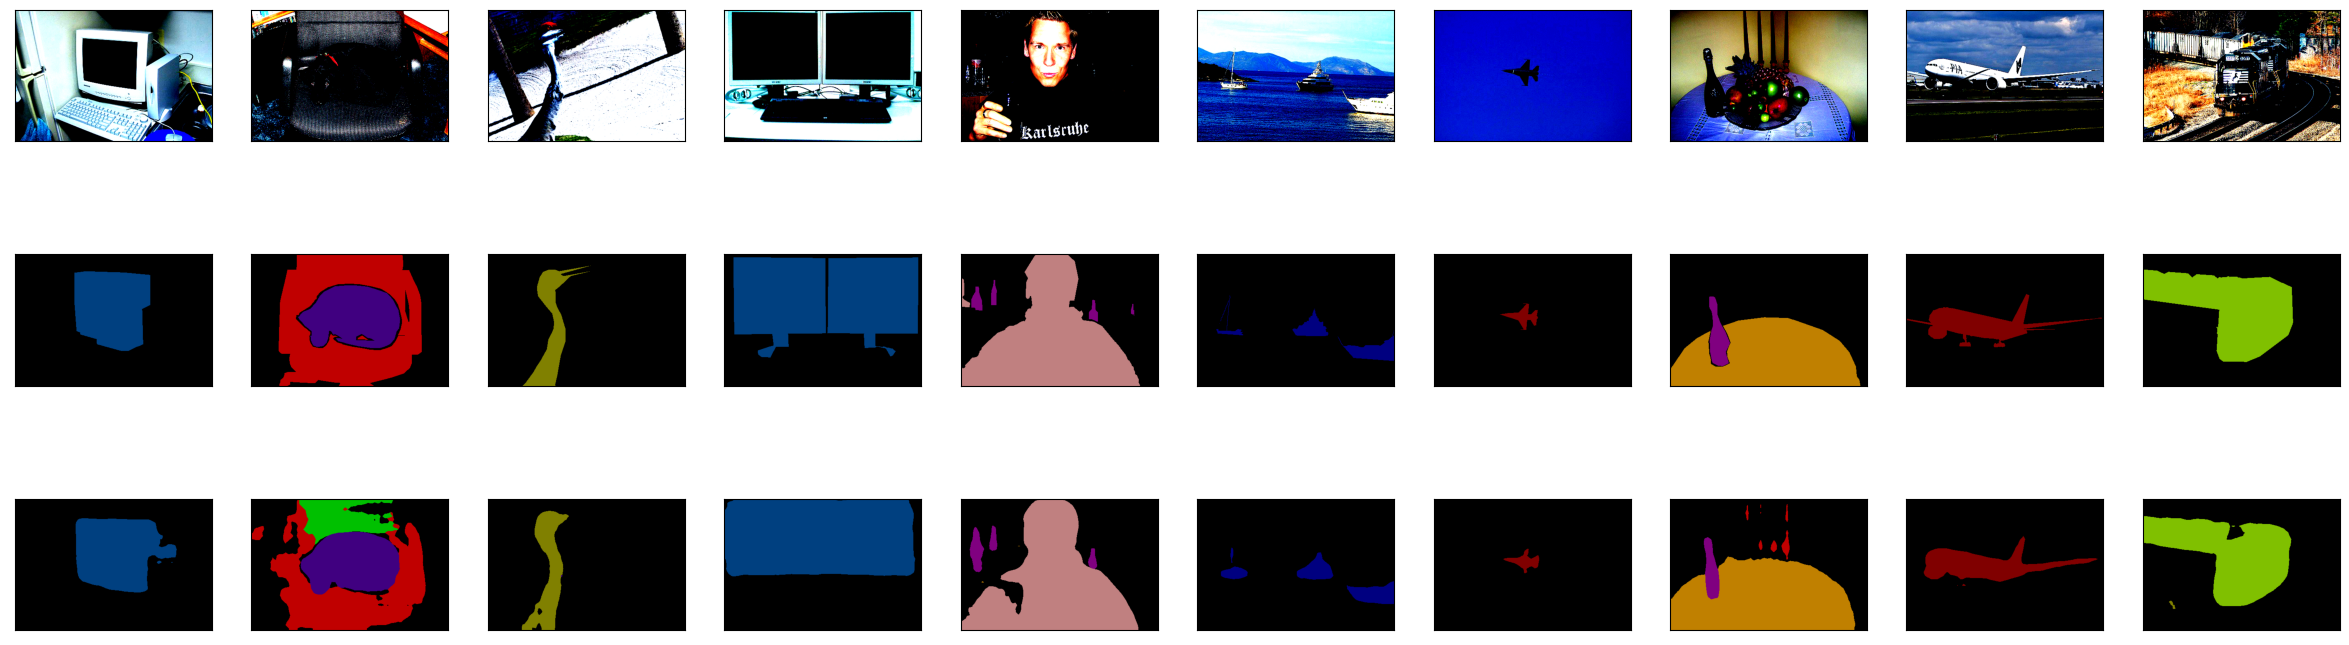

In [9]:
from d2l import torch as d2l

# 推理模式（batchnorm,dropout层)
model.eval()
# 取10张图片组成batch
batch=[]
target=[]
for i in range(10):
    batch.append(dataset[i][0])
    target.append(dataset[i][1])

batch=torch.stack(batch)
target=torch.stack(target)
print(batch.shape,target.shape)

# 预测每个像素点的21个分类概率【模型是通过最后卷积出21个通道实现的】
output=model(batch)
output=output['out']
print(output.shape)

# 取每个像素点的最大概率分类ID
output=torch.argmax(output,dim=1)
print(output.shape)

# 像素分类ID转回颜色
imgs_raw=[]
imgs_target=[]
imgs_predict=[]
for i in range(10):
    output_img=voc_label2colormap(output[i]) # [320,480,] -> [320,480,3]
    imgs_raw.append(batch[i].permute(1,2,0)) # 原图 [3,320,480] -> [320,480,3]
    imgs_target.append(voc_label2colormap(target[i]))
    imgs_predict.append(output_img) # 预测图
d2l.show_images(imgs_raw+imgs_target+imgs_predict, 3,10, scale=3) # 打印原图和语义分割结果

In [11]:
# 多分类交叉熵,不需要自己做softmax
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

# 开始训练
epoch=1
dataloader = torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)
model.train()

for i in range(epoch):
    batch_i=0
    for inputs,targets in dataloader:
        inputs=inputs
        targets=targets
        #print(inputs.shape,targets.shape)
        outputs=model(inputs)
        loss=loss_fn(outputs['out'],targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('epoch={} batch={} loss={}'.format(i,batch_i,loss))

OutOfMemoryError: CUDA out of memory. Tried to allocate 76.00 MiB (GPU 0; 6.00 GiB total capacity; 5.18 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF